In [1]:
%matplotlib inline
#
from LRGSG_package.shared import *
from LRGSG_package.config.utils import log_binning
from LRGSG_package.LRGSG import Lattice2D, SignedRW, move_to_rootf
#
move_to_rootf(print_tf=True)
plt.style.use("ipynb/nb_plotsheet.mplstyle")

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


Current value of p: 0


KeyError: 8

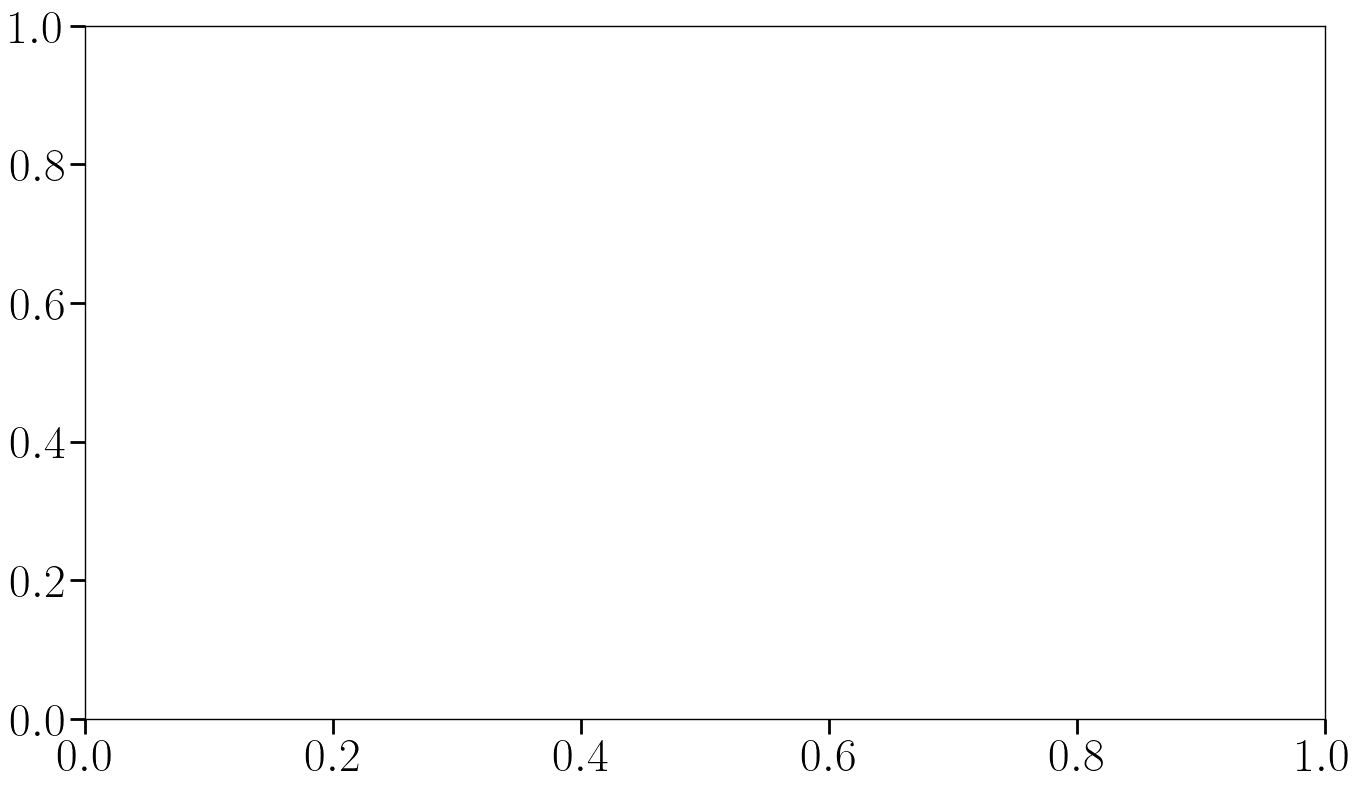

In [2]:
fig, ax = plt.subplots()

for p in [0, 0.1, 0.5]:
    print("Current value of p:", p)  # Debugging statement to check p
    l = Lattice2D(12, pflip=p)
    l.flip_random_fract_edges()
    srw = SignedRW(l, simTime=1000, 
               initMode="random", 
               runMode="py",
               storeMode="sequential",
               storeFreq=1)
    srw.run()
    a = np.array(srw.s_tList, dtype=object)[:, 1].astype(int)
    changes = np.where(np.diff(a) != 0)[0] + 1
    sequence_lengths = np.diff(np.hstack(([0], changes, [len(a)])))
    print("Sequence lengths:", sequence_lengths)
    b, h, w = log_binning(sequence_lengths, binnum=15)
    ax.plot(b, h/w)
    ax.set_yscale("log")
    ax.set_xscale("log")
    del srw  # Clean up
    del l  # Clean up
plt.show()


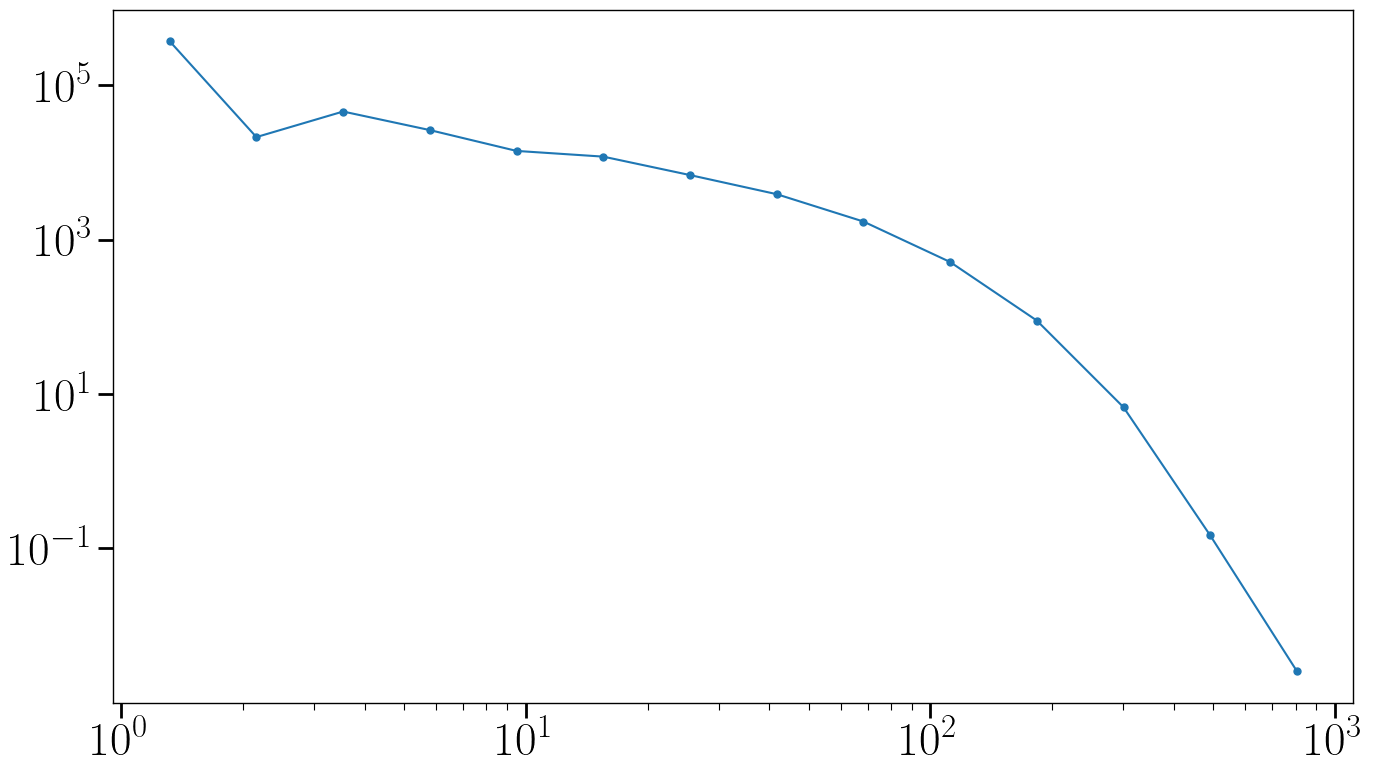

In [ ]:
b, h, w = log_binning(sequence_lengths, binnum=15)
plt.plot(b, h/w)
plt.yscale("log")
plt.xscale("log")

In [42]:
a.alpha

2.413878051037931